In [1]:
import tensorflow.keras.backend as K
import multiprocessing

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import random
import logging

from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

In [2]:
# Set random seed (for reproducibility)
np.random.seed(1000)

In [3]:
#dataset_location = './datasets/sarcasm_v2.csv'
dataset_location = './datasets/text_and_annorations.csv'

corpus = []
labels = []

In [4]:
#Shuffle the dataset

ip=open(dataset_location,'r', encoding="utf8")
next(ip)   #ignore the first row (label row)
li = ip.readlines()
random.shuffle(li)

#dataset_location = './datasets/shuffled_sarcasm_v2.csv'
dataset_location = './datasets/shuffled_text_and_annotations.csv'

fid = open(dataset_location, "w", encoding="utf8")
fid.writelines(li)
fid.close()

In [5]:
# Parse tweets and sentiments       
with open(dataset_location, 'r', encoding="utf8") as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    
    #skip the first line?
    #next(csvReader)
    
    for row in csvReader:
        #corpus.append(row[3] + " - " + row[4])
        corpus.append(row[1])

        #Sarcasm label, (0 = not sarcasm, 1 = sarcasm)
        #pol = 1 if row[1] == 'sarc' else 0
        pol = 1 if row[5] == 'Yes' else 0
        labels.append(pol)
        
print('Corpus size: {}'.format(len(corpus)))

Corpus size: 994


In [6]:
# Tokenize and stem
tkr = RegexpTokenizer('[a-zA-Z0-9@]+')
#stemmer = LancasterStemmer()

tokenized_corpus = []

for i, tweet in enumerate(corpus):
    #tokens = [stemmer.stem(t) for t in tkr.tokenize(tweet) if not t.startswith('@')]
    tokens = [t for t in tkr.tokenize(tweet) if not t.startswith('@')]
    tokenized_corpus.append(tokens)

In [7]:
vector_size = 200
window_size = 10

In [8]:
# Load the GloVe embeddings from twitter 
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
embeddings_dict = {}
with open("./glove/glove.twitter.27B.200d.txt", "r",encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [9]:
X_vecs = embeddings_dict
del corpus

In [10]:
# Train subset size (0 < size < len(tokenized_corpus))
train_size = math.floor(0.8 * len(tokenized_corpus))

# Test subset size (0 < size < len(tokenized_corpus) - train_size)
test_size = len(tokenized_corpus) - train_size

# Compute average and max tweet length
avg_length = 0.0
max_length = 0

for tweet in tokenized_corpus:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tokenized_corpus))))
print('Max tweet length: {}'.format(max_length))

Average tweet length: 23.5523138832998
Max tweet length: 201


In [11]:
# Tweet max length (number of tokens)
max_tweet_length = max_length

In [12]:
# Create train and test sets
# Generate random indexes
indexes = set(np.random.choice(len(tokenized_corpus), train_size + test_size, replace=False))

X_train = np.zeros((train_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((train_size, 2), dtype=np.int32)
X_test = np.zeros((test_size, max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((test_size, 2), dtype=np.int32)

for i, index in enumerate(indexes):
    for t, token in enumerate(tokenized_corpus[index]):
        if t >= max_tweet_length:
            break

        if token not in X_vecs:
            continue
    
        if i < train_size:
            X_train[i, t, :] = X_vecs[token]
        else:
            X_test[i - train_size, t, :] = X_vecs[token]
            
    if i < train_size:
        Y_train[i, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0]
    else:
        Y_test[i - train_size, :] = [1.0, 0.0] if labels[index] == 0 else [0.0, 1.0] 

In [13]:
batch_size = 16
nb_epochs = 20

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, input_shape=(max_tweet_length, vector_size)))
model.add(tf.keras.layers.GRU(128, return_sequences='true'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 201, 64)           12864     
_________________________________________________________________
gru (GRU)                    (None, 201, 128)          74496     
_________________________________________________________________
flatten (Flatten)            (None, 25728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 51458     
Total params: 138,818
Trainable params: 138,818
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [15]:
# Fit the model
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=nb_epochs,
          validation_data=(X_test, Y_test))

Train on 795 samples, validate on 199 samples
Epoch 1/20
795/795 [==============================] - 13s 17ms/sample - loss: 0.6252 - accuracy: 0.6377 - val_loss: 0.6011 - val_accuracy: 0.6683
Epoch 2/20
795/795 [==============================] - 10s 12ms/sample - loss: 0.6015 - accuracy: 0.6730 - val_loss: 0.5961 - val_accuracy: 0.6935
Epoch 3/20
795/795 [==============================] - 9s 11ms/sample - loss: 0.5901 - accuracy: 0.7094 - val_loss: 0.5863 - val_accuracy: 0.7286
Epoch 4/20
795/795 [==============================] - 11s 14ms/sample - loss: 0.5705 - accuracy: 0.7673 - val_loss: 0.5775 - val_accuracy: 0.7236
Epoch 5/20
795/795 [==============================] - 11s 14ms/sample - loss: 0.5395 - accuracy: 0.8101 - val_loss: 0.5379 - val_accuracy: 0.7940
Epoch 6/20
795/795 [==============================] - 11s 13ms/sample - loss: 0.4988 - accuracy: 0.8252 - val_loss: 0.5118 - val_accuracy: 0.7688
Epoch 7/20
795/795 [==============================] - 9s 11ms/sample - loss: 0.

In [16]:
loss, accuracy = model.evaluate(X_test, Y_test)

print("Loss: ", "%.3f" % loss)
print("Accuracy: ", "%.3f" % accuracy)

199/199 [==============================] - 0s 2ms/sample - loss: 0.4714 - accuracy: 0.8392
Loss:  0.471
Accuracy:  0.839


# Graph

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

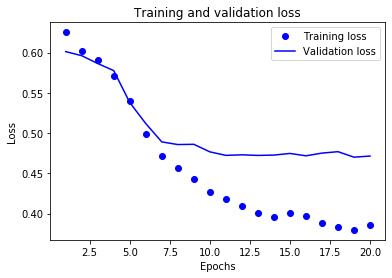

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

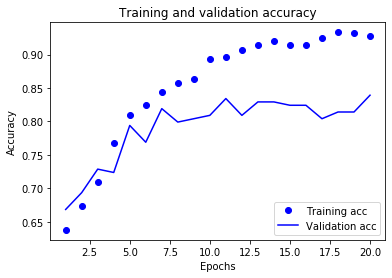

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()